In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import resample
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# List of columns where NaNs are allowed
allowed_nan_columns = [
    'TOTAL_LINE_MOVEMENT_3',
    'SPREAD_LINE_MOVEMENT_3',
    'SPREAD_LINE_MOVEMENT_1',
    'TOTAL_LINE_MOVEMENT_2',
    'SPREAD_LINE_MOVEMENT_2',
    'TOTAL_LINE_MOVEMENT_1',
    'HOME TEAM WIN%',
    'CREW',
    'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)',
    'HOME TEAM POINTS DIFFERENTIAL',
    'MAIN REF',
    'FOUL% AGAINST HOME TEAMS',
    'TOTAL POINTS PER GAME',
    'CALLED FOULS PER GAME',
    'FOUL% AGAINST ROAD TEAMS'
]

### implementation

#### helpers

In [2]:
def calculate_profit(odds, size):
    if odds > 0:
        profit = (odds / 100) * size
    else:
        profit = (100 / -(odds + 0.0000001)) * size
    return profit

def kelly_criterion(bankroll, probability, odds, temper=1):
    """
    Calculate the optimal bet size using the Kelly Criterion.

    :param bankroll: Total amount of money you have to bet with.
    :param probability: The probability of the bet winning (from 0 to 1).
    :param odds: The odds being offered on the bet (in decimal format).
    :return: The recommended bet size according to the Kelly Criterion.
    """
    # Convert American odds to decimal if necessary
    if odds > 0:
        odds = (odds / 100) + 1
    elif odds < 0:
        odds = (100 / -odds) + 1

    # Calculate the Kelly bet fraction
    b = odds - 1  # Decimal odds minus 1
    q = 1 - probability  # Probability of losing
    kelly_fraction = (b * probability - q) / b

    # Calculate the recommended bet
    recommended_bet = (temper * kelly_fraction) * bankroll

    return recommended_bet

#### model

In [46]:
import numpy as np
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
import joblib

class BootstrapCalibratedClassifier:
    def __init__(self, n_bootstrap_samples=8, base_model_params=None):
        self.n_bootstrap_samples = n_bootstrap_samples
        self.bootstrap_models = []
        self.calibrated_models = []
        self.base_model_params = base_model_params if base_model_params else {
            'tree_method': "hist",
            'enable_categorical': True,
            'verbosity': 1,
            'max_depth': 7,
            'learning_rate': 0.022,
            'n_estimators': 300,
            'gamma': 7,
            'subsample': 1,
            'colsample_bytree': 0.8,
            'min_child_weight': 15,
            'reg_lambda': 0.3,
            'reg_alpha': 0.3,
        }

    def fit(self, X_train, y_train):
        for _ in range(self.n_bootstrap_samples):
            # Bootstrap sample generation
            X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=len(X_train), replace=True)
            
            # Train base model
            model = xgb.XGBClassifier(**self.base_model_params)
            model.fit(X_train_sample, y_train_sample)
            self.bootstrap_models.append(model)
            
            # Calibrate the model
            calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
            calibrated_model.fit(X_train_sample, y_train_sample)
            self.calibrated_models.append(calibrated_model)

    def predict(self, X):
        # Aggregate predictions from bootstrap models
        preds = np.array([model.predict(X) for model in self.bootstrap_models])
        return np.round(np.mean(preds, axis=0)).astype(int)

    def predict_proba(self, X):
        # Aggregate calibrated predicted probabilities from bootstrap models
        proba = np.array([calibrated_model.predict_proba(X) for calibrated_model in self.calibrated_models])
        # Average probabilities across all bootstrap models
        return np.mean(proba, axis=0)

    def score(self, X_test, y_test):
        """
        This method calculates the accuracy score of the model.
        It compares the predicted labels with the true labels.
        """
        predictions = self.predict(X_test)
        return accuracy_score(y_test, predictions)

    def save_model(self, filename):
        """Save the trained models to a file."""
        for idx, model in enumerate(self.bootstrap_models):
            model_path = f"{filename}_model_{idx}.pkl"
            joblib.dump(model, model_path)
        
        # Save calibrated models
        for idx, calibrated_model in enumerate(self.calibrated_models):
            calibrated_model_path = f"{filename}_calibrated_{idx}.pkl"
            joblib.dump(calibrated_model, calibrated_model_path)
        print(f"Models saved to {filename}")

    def load_model(self, filename):
        """Load both base and calibrated models."""
        self.bootstrap_models = []
        self.calibrated_models = []
        
        for idx in range(self.n_bootstrap_samples):
            base_model_path = f"{filename}_model_{idx}.pkl"
            calibrated_model_path = f"{filename}_calibrated_{idx}.pkl"
            
            base_model = joblib.load(base_model_path)
            calibrated_model = joblib.load(calibrated_model_path)
            
            self.bootstrap_models.append(base_model)
            self.calibrated_models.append(calibrated_model)
        print(f"Models loaded from {filename}")


#### backtest

In [35]:
# Constants
THRESHOLD = 0.5

def process_data_frame(df):
    """Convert DATE to datetime and sort the DataFrame."""
    df['DATE'] = pd.to_datetime(df['DATE'])
    return df.sort_values('DATE')

def update_bankroll(bankroll, profit):
    """Update bankroll, ensuring it doesn't go negative."""
    return max(bankroll + profit, 0)

def print_bet_results(date, wins, losses, total, bankroll, start, made_a_bet, all_odds):
    """Print results of betting for the day."""
    win_rate = wins / total if total > 0 else 0
    print(f'Results for {date}: Start Bankroll: {round(start, 2)}, End Bankroll: {round(bankroll, 2)}, '
          f'Profit: {round(bankroll - start, 2)}, Win Rate: {win_rate:.2f}\n')

def prepare_features(day_data, feature_cols):
    """Prepare features for prediction."""
    X = day_data[feature_cols].copy()
    # Prepare features
    X[['Elo_Rating', 'Momentum']] = X[['Elo_Rating', 'Momentum']].shift()
    X[["MONEYLINE", "Last_ML_1", "Last_ML_2", "Last_ML_3"]] = (
        X[["MONEYLINE", "Last_ML_1", "Last_ML_2", "Last_ML_3"]]
        .replace('even', '-100', regex=True)
        .fillna(0)
        .astype(int)
    )
    # Convert categorical columns
    for col in ['MAIN REF', 'TEAM', 'CREW', 'Opponent', 'TEAM_REST_DAYS']:
        X[col] = X[col].astype('category')
    X['VENUE'] = (X['VENUE'] == 'H').astype(int)
    return X

def calculate_bets(X, model, y, threshold=THRESHOLD):
    """Calculate betting decisions based on predictions."""
    probabilities = model.predict_proba(X)[:, 1]
    predictions = probabilities > threshold
    # Calculate normalized odds and betting decisions
    ps = {team: prob for team, prob in zip(X['TEAM'], probabilities)}
    normed_odds = {team: ps[team] / (ps[team] + ps[opp]) for team, opp in zip(X['TEAM'], X['Opponent'])}
    do_bet = {team: normed_odds[team] > normed_odds[opp] for team, opp in zip(X['TEAM'], X['Opponent'])}
    
    return predictions, probabilities, do_bet, normed_odds

def process_daily_bets(day_data, model, bankroll, bet_size, y, feature_cols, odds_col, threshold=THRESHOLD):
    """Process bets for a single day."""
    X = prepare_features(day_data, feature_cols)
    predictions, probabilities, do_bet, normed_odds = calculate_bets(X, model, y, threshold)

    wins, losses, day_profit, num_bets = 0, 0, 0, 0
    all_odds = []

    for pred, actual, odds, team, opp in zip(predictions, y, X[odds_col], X['TEAM'], X['Opponent']):
        if do_bet[team]:
            
            if odds_col == 'Momentum':
                odds = 300
            elif odds_col != 'MONEYLINE':
                odds = -110
                
            bet_size = round(kelly_criterion(bankroll, normed_odds[team], odds, 0.10), 2)

            if (bankroll - bet_size) >= 0 and bet_size > 0:
                to_win = round(calculate_profit(odds, bet_size), 2)
                bankroll -= bet_size
                num_bets += 1

                if actual:
                    display(HTML(f'<span style="color: green;">Won {to_win} betting {bet_size} on {team} vs {opp} at {odds}</span>'))
                    day_profit += (to_win + bet_size)
                    wins += 1
                else:
                    display(HTML(f'<span style="color: red;">Lost {bet_size} betting on {team} vs {opp} at {odds}</span>'))
                    losses += actual != pred
                all_odds.append(odds)

    return bankroll + day_profit, wins, losses, num_bets, all_odds

def backtest_model(df, model, feature_cols, label_col, odds_col, start_date, end_date, initial_bankroll, bet_size, threshold=THRESHOLD):
    """Backtest the betting model over a specified date range."""
    df = process_data_frame(df)
    bankroll = initial_bankroll
    bet_results = []
    current_date = pd.to_datetime(start_date)

    while current_date <= pd.to_datetime(end_date):
        print(f'Processing {current_date}...')
        day_data = df[df['DATE'] == current_date]
        start_bankroll = bankroll

        if not day_data.empty and bankroll > 0:
            y = day_data[label_col]
            bankroll, wins, losses, num_bets, all_odds = process_daily_bets(day_data, model, bankroll, bet_size, y, feature_cols, odds_col, threshold) 
            print_bet_results(current_date, wins, losses, num_bets, bankroll, start_bankroll, len(all_odds) > 0, all_odds)
            bet_results.append(bankroll)

        current_date += pd.Timedelta(days=1)

    return bankroll, bankroll - initial_bankroll, bet_results


### load data

In [5]:
df = pd.read_csv('2024_2025_nba_team_full.csv')

# Dropping rows with NaN values, except in specified columns
#df = df.dropna(subset=[col for col in df.columns if col not in allowed_nan_columns])

# flip true and false in ml_result column
df['ml_result'] = df['ml_result'].apply(lambda x: True if x == False else False)

# convert categorical columns
df['MAIN REF'] = df['MAIN REF'].astype('category')
df['CREW'] = df['CREW'].astype('category')
df['TEAM_REST_DAYS'] = df['TEAM_REST_DAYS'].astype('category')
df['TEAM'] = df['TEAM'].astype('category')
df['Opponent'] = df['Opponent'].astype('category')

# convert venue to binary
df['VENUE'] = (df['VENUE'] == 'H')*1

# convert date to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

### train / test / val split

In [16]:
X = df.drop(columns=['spread_result', 'ml_result', 'total_result', 'q3_result', 'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS'])
y_ml = df['ml_result']
y_spread = df['spread_result']
y_q3 = df['q3_result']
y_total = df['total_result']

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X, y_ml, test_size=0.2, random_state=42)
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(X_train_ml, y_train_ml, test_size=0.1, random_state=41)

X_train_spread, X_test_spread, y_train_spread, y_test_spread = train_test_split(X, y_spread, test_size=0.2, random_state=42)
X_train_spread, X_val_spread, y_train_spread, y_val_spread = train_test_split(X_train_spread, y_train_spread, test_size=0.1, random_state=41)

X_train_q3, X_test_q3, y_train_q3, y_test_q3 = train_test_split(X, y_q3, test_size=0.2, random_state=42)
X_train_q3, X_val_q3, y_train_q3, y_val_q3 = train_test_split(X_train_q3, y_train_q3, test_size=0.1, random_state=41)

X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y_total, test_size=0.2, random_state=42)
X_train_total, X_val_total, y_train_total, y_val_total = train_test_split(X_train_total, y_train_total, test_size=0.1, random_state=41)

### train

In [56]:
# Usage
ml_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
ml_model.fit(X_train_ml, y_train_ml)
print("Average ML Score:", ml_model.score(X_test_ml, y_test_ml))

Average ML Score: 0.6605058365758755


In [58]:
best = None
best_score = 0
for _ in range(10):
    spread_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
    spread_model.fit(X_train_spread, y_train_spread)
    score = spread_model.score(X_test_spread, y_test_spread)
    if score > best_score:
        best = spread_model
        best_score = score
    print("Average Spread Score:", score)

Average Spread Score: 0.5003242542153048
Average Spread Score: 0.4974059662775616
Average Spread Score: 0.5113488975356679
Average Spread Score: 0.5006485084306096
Average Spread Score: 0.49383916990920884
Average Spread Score: 0.488651102464332
Average Spread Score: 0.501621271076524
Average Spread Score: 0.5022697795071336
Average Spread Score: 0.5149156939040207
Average Spread Score: 0.49578469520103763


In [59]:
total_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
total_model.fit(X_train_total, y_train_total)
print("Average Total Score:", total_model.score(X_test_total, y_test_total))

Average Total Score: 0.5346952010376135


In [60]:
ml_model.save_model('ml_model')
best.save_model('spread_model')
total_model.save_model('total_model')

Models saved to ml_model
Models saved to spread_model
Models saved to total_model


#### train 3q

In [39]:
# calculate the ratio of 0 to 1 in the q3_result column
num_positive = y_train_q3.sum()
num_negative = len(y_train_q3) - num_positive
scale_pos_weight = num_negative / num_positive
params = {
    'tree_method': "hist",
    'sampling_method': 'gradient_based',
    'enable_categorical': True,
    'device': "cuda",
    'verbosity': 1,
    'max_depth': 7,
    'learning_rate': 0.022,
    'n_estimators': 300,
    'gamma': 7,
    'subsample': 1,
    'colsample_bytree': 0.8,
    'min_child_weight': 15,
    'reg_lambda': 0.3,
    'reg_alpha': 0.3,
    'scale_pos_weight': scale_pos_weight/2
    }

q3_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5, base_model_params=params)
q3_model.fit(X_train_q3, y_train_q3)
print("Average 3Q Score:", q3_model.score(X_test_q3, y_test_q3))

Average 3Q Score: 0.883916990920882


### backtesting

In [31]:
drop_cols = ['spread_result', 'ml_result', 'total_result', 'q3_result', 'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS']

#### spread

Processing 2024-10-22 00:00:00...


Results for 2024-10-22 00:00:00: Start Bankroll: 2500, End Bankroll: 2485.36, Profit: -14.64, Win Rate: 0.50

Processing 2024-10-23 00:00:00...


Results for 2024-10-23 00:00:00: Start Bankroll: 2485.36, End Bankroll: 2836.15, Profit: 350.79, Win Rate: 0.71

Processing 2024-10-24 00:00:00...


Results for 2024-10-24 00:00:00: Start Bankroll: 2836.15, End Bankroll: 3024.88, Profit: 188.73, Win Rate: 1.00

Processing 2024-10-25 00:00:00...


Results for 2024-10-25 00:00:00: Start Bankroll: 3024.88, End Bankroll: 3238.78, Profit: 213.9, Win Rate: 0.57

Processing 2024-10-26 00:00:00...


Results for 2024-10-26 00:00:00: Start Bankroll: 3238.78, End Bankroll: 3505.38, Profit: 266.6, Win Rate: 0.80

Processing 2024-10-27 00:00:00...


Results for 2024-10-27 00:00:00: Start Bankroll: 3505.38, End Bankroll: 4228.34, Profit: 722.96, Win Rate: 1.00

Processing 2024-10-28 00:00:00...


Results for 2024-10-28 00:00:00: Start Bankroll: 4228.34, End Bankroll: 4718.87, Profit: 490.53, Win Rate: 0.75

Processing 2024-10-29 00:00:00...


Results for 2024-10-29 00:00:00: Start Bankroll: 4718.87, End Bankroll: 5369.02, Profit: 650.15, Win Rate: 1.00

Processing 2024-10-30 00:00:00...


Results for 2024-10-30 00:00:00: Start Bankroll: 5369.02, End Bankroll: 5277.48, Profit: -91.54, Win Rate: 0.60

Processing 2024-10-31 00:00:00...


Results for 2024-10-31 00:00:00: Start Bankroll: 5277.48, End Bankroll: 5209.19, Profit: -68.29, Win Rate: 0.67

Processing 2024-11-01 00:00:00...


Results for 2024-11-01 00:00:00: Start Bankroll: 5209.19, End Bankroll: 6024.16, Profit: 814.97, Win Rate: 0.75

Processing 2024-11-02 00:00:00...


Results for 2024-11-02 00:00:00: Start Bankroll: 6024.16, End Bankroll: 6193.67, Profit: 169.51, Win Rate: 0.70

Processing 2024-11-03 00:00:00...


Results for 2024-11-03 00:00:00: Start Bankroll: 6193.67, End Bankroll: 6298.58, Profit: 104.91, Win Rate: 0.67

Processing 2024-11-04 00:00:00...


Results for 2024-11-04 00:00:00: Start Bankroll: 6298.58, End Bankroll: 8297.04, Profit: 1998.46, Win Rate: 0.86

Processing 2024-11-05 00:00:00...
Processing 2024-11-06 00:00:00...


Results for 2024-11-06 00:00:00: Start Bankroll: 8297.04, End Bankroll: 8328.1, Profit: 31.06, Win Rate: 0.55



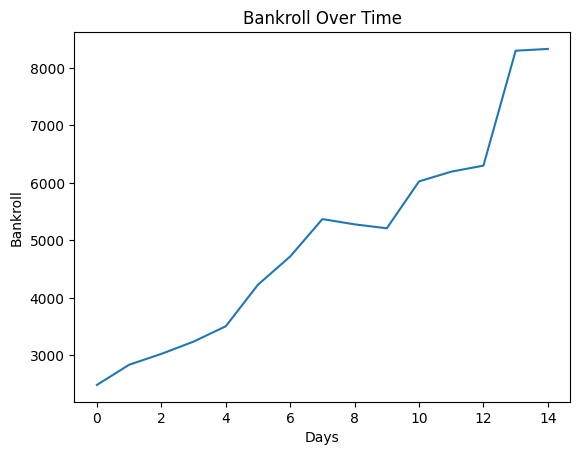

Final Bankroll: 8328.100000000006
Total Profit: 5828.100000000006


In [29]:
# Example usage with defined constants
final_bankroll, total_profit, bet_results = backtest_model(
    df=df,
    model=spread_model,
    feature_cols=df.drop(drop_cols, axis=1).columns,  # Feature columns
    label_col='spread_result',
    odds_col='CLOSING_SPREAD',
    start_date='2024-10-22',
    end_date='2024-11-06',
    initial_bankroll=2500,
    bet_size=2
)

# Plotting the results
plt.plot(bet_results)
plt.title('Bankroll Over Time')
plt.xlabel('Days')
plt.ylabel('Bankroll')
plt.show()

print(f"Final Bankroll: {final_bankroll}")
print(f"Total Profit: {total_profit}")

#### ML

Processing 2024-10-22 00:00:00...


Results for 2024-10-22 00:00:00: Start Bankroll: 2500, End Bankroll: 2576.68, Profit: 76.68, Win Rate: 1.00

Processing 2024-10-23 00:00:00...


Results for 2024-10-23 00:00:00: Start Bankroll: 2576.68, End Bankroll: 2770.96, Profit: 194.28, Win Rate: 0.90

Processing 2024-10-24 00:00:00...


Results for 2024-10-24 00:00:00: Start Bankroll: 2770.96, End Bankroll: 2854.63, Profit: 83.67, Win Rate: 1.00

Processing 2024-10-25 00:00:00...


Results for 2024-10-25 00:00:00: Start Bankroll: 2854.63, End Bankroll: 2822.16, Profit: -32.47, Win Rate: 0.62

Processing 2024-10-26 00:00:00...


Results for 2024-10-26 00:00:00: Start Bankroll: 2822.16, End Bankroll: 2782.13, Profit: -40.03, Win Rate: 0.70

Processing 2024-10-27 00:00:00...


Results for 2024-10-27 00:00:00: Start Bankroll: 2782.13, End Bankroll: 2247.01, Profit: -535.12, Win Rate: 0.20

Processing 2024-10-28 00:00:00...


Results for 2024-10-28 00:00:00: Start Bankroll: 2247.01, End Bankroll: 2317.65, Profit: 70.64, Win Rate: 0.70

Processing 2024-10-29 00:00:00...


Results for 2024-10-29 00:00:00: Start Bankroll: 2317.65, End Bankroll: 2515.07, Profit: 197.42, Win Rate: 1.00

Processing 2024-10-30 00:00:00...


Results for 2024-10-30 00:00:00: Start Bankroll: 2515.07, End Bankroll: 2137.14, Profit: -377.93, Win Rate: 0.36

Processing 2024-10-31 00:00:00...


Results for 2024-10-31 00:00:00: Start Bankroll: 2137.14, End Bankroll: 2053.09, Profit: -84.05, Win Rate: 0.50

Processing 2024-11-01 00:00:00...


Results for 2024-11-01 00:00:00: Start Bankroll: 2053.09, End Bankroll: 2208.16, Profit: 155.07, Win Rate: 0.78

Processing 2024-11-02 00:00:00...


Results for 2024-11-02 00:00:00: Start Bankroll: 2208.16, End Bankroll: 2178.65, Profit: -29.51, Win Rate: 0.62

Processing 2024-11-03 00:00:00...


Results for 2024-11-03 00:00:00: Start Bankroll: 2178.65, End Bankroll: 2193.36, Profit: 14.71, Win Rate: 0.67

Processing 2024-11-04 00:00:00...


Results for 2024-11-04 00:00:00: Start Bankroll: 2193.36, End Bankroll: 2267.49, Profit: 74.13, Win Rate: 0.73

Processing 2024-11-05 00:00:00...
Processing 2024-11-06 00:00:00...


Results for 2024-11-06 00:00:00: Start Bankroll: 2267.49, End Bankroll: 2287.8, Profit: 20.31, Win Rate: 0.75



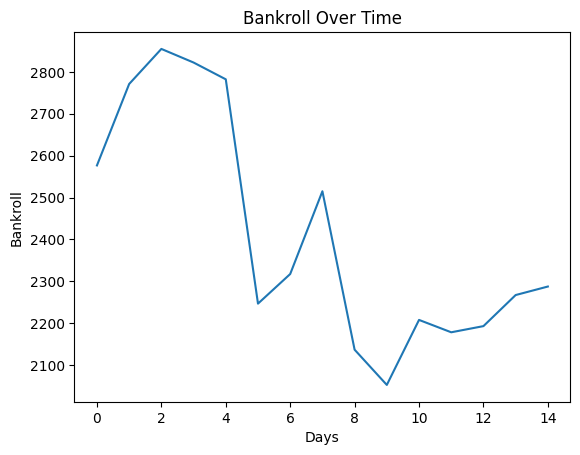

Final Bankroll: 2287.8
Total Profit: -212.19999999999982


In [32]:
# Example usage with defined constants
final_bankroll, total_profit, bet_results = backtest_model(
    df=df,
    model=ml_model,
    feature_cols=df.drop(drop_cols, axis=1).columns,  # Feature columns
    label_col='ml_result',
    odds_col='MONEYLINE',
    start_date='2024-10-22',
    end_date='2024-11-06',
    initial_bankroll=2500,
    bet_size=2
)

# Plotting the results
plt.plot(bet_results)
plt.title('Bankroll Over Time')
plt.xlabel('Days')
plt.ylabel('Bankroll')
plt.show()

print(f"Final Bankroll: {final_bankroll}")
print(f"Total Profit: {total_profit}")

#### total

Processing 2024-10-22 00:00:00...


Results for 2024-10-22 00:00:00: Start Bankroll: 2500, End Bankroll: 2695.48, Profit: 195.48, Win Rate: 1.00

Processing 2024-10-23 00:00:00...


Results for 2024-10-23 00:00:00: Start Bankroll: 2695.48, End Bankroll: 3271.4, Profit: 575.92, Win Rate: 0.78

Processing 2024-10-24 00:00:00...


Results for 2024-10-24 00:00:00: Start Bankroll: 3271.4, End Bankroll: 3253.9, Profit: -17.5, Win Rate: 0.50

Processing 2024-10-25 00:00:00...


Results for 2024-10-25 00:00:00: Start Bankroll: 3253.9, End Bankroll: 3064.26, Profit: -189.64, Win Rate: 0.60

Processing 2024-10-26 00:00:00...


Results for 2024-10-26 00:00:00: Start Bankroll: 3064.26, End Bankroll: 2622.26, Profit: -442.0, Win Rate: 0.40

Processing 2024-10-27 00:00:00...


Results for 2024-10-27 00:00:00: Start Bankroll: 2622.26, End Bankroll: 2758.02, Profit: 135.76, Win Rate: 0.60

Processing 2024-10-28 00:00:00...


Results for 2024-10-28 00:00:00: Start Bankroll: 2758.02, End Bankroll: 2324.81, Profit: -433.21, Win Rate: 0.36

Processing 2024-10-29 00:00:00...


Results for 2024-10-29 00:00:00: Start Bankroll: 2324.81, End Bankroll: 2419.03, Profit: 94.22, Win Rate: 0.75

Processing 2024-10-30 00:00:00...


Results for 2024-10-30 00:00:00: Start Bankroll: 2419.03, End Bankroll: 1930.32, Profit: -488.71, Win Rate: 0.45

Processing 2024-10-31 00:00:00...


Results for 2024-10-31 00:00:00: Start Bankroll: 1930.32, End Bankroll: 1765.15, Profit: -165.17, Win Rate: 0.25

Processing 2024-11-01 00:00:00...


Results for 2024-11-01 00:00:00: Start Bankroll: 1765.15, End Bankroll: 2210.1, Profit: 444.95, Win Rate: 0.89

Processing 2024-11-02 00:00:00...


Results for 2024-11-02 00:00:00: Start Bankroll: 2210.1, End Bankroll: 1951.54, Profit: -258.56, Win Rate: 0.50

Processing 2024-11-03 00:00:00...


Results for 2024-11-03 00:00:00: Start Bankroll: 1951.54, End Bankroll: 1809.19, Profit: -142.35, Win Rate: 0.33

Processing 2024-11-04 00:00:00...


Results for 2024-11-04 00:00:00: Start Bankroll: 1809.19, End Bankroll: 2085.88, Profit: 276.69, Win Rate: 0.57

Processing 2024-11-05 00:00:00...
Processing 2024-11-06 00:00:00...


Results for 2024-11-06 00:00:00: Start Bankroll: 2085.88, End Bankroll: 2474.95, Profit: 389.07, Win Rate: 0.67



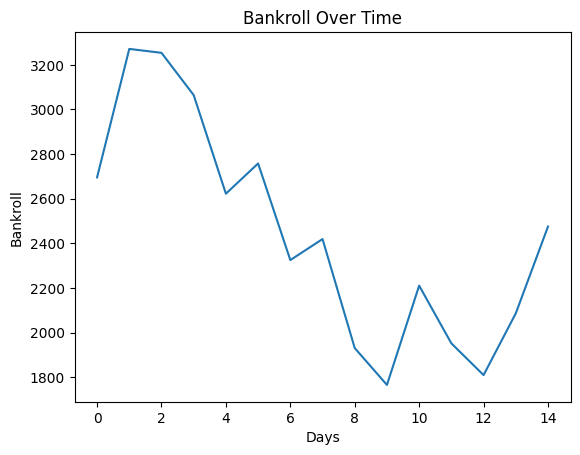

Final Bankroll: 2474.949999999999
Total Profit: -25.05000000000109


In [33]:
# Example usage with defined constants
final_bankroll, total_profit, bet_results = backtest_model(
    df=df,
    model=ml_model,
    feature_cols=df.drop(drop_cols, axis=1).columns,  # Feature columns
    label_col='total_result',
    odds_col='CLOSING_TOTAL',
    start_date='2024-10-22',
    end_date='2024-11-06',
    initial_bankroll=2500,
    bet_size=2
)

# Plotting the results
plt.plot(bet_results)
plt.title('Bankroll Over Time')
plt.xlabel('Days')
plt.ylabel('Bankroll')
plt.show()

print(f"Final Bankroll: {final_bankroll}")
print(f"Total Profit: {total_profit}")

#### 3q

Processing 2024-10-22 00:00:00...


Results for 2024-10-22 00:00:00: Start Bankroll: 2500, End Bankroll: 3101.52, Profit: 601.52, Win Rate: 0.50

Processing 2024-10-23 00:00:00...


Results for 2024-10-23 00:00:00: Start Bankroll: 3101.52, End Bankroll: 3174.94, Profit: 73.42, Win Rate: 0.20

Processing 2024-10-24 00:00:00...


Results for 2024-10-24 00:00:00: Start Bankroll: 3174.94, End Bankroll: 2393.02, Profit: -781.92, Win Rate: 0.00

Processing 2024-10-25 00:00:00...


Results for 2024-10-25 00:00:00: Start Bankroll: 2393.02, End Bankroll: 1147.43, Profit: -1245.59, Win Rate: 0.00

Processing 2024-10-26 00:00:00...


Results for 2024-10-26 00:00:00: Start Bankroll: 1147.43, End Bankroll: 530.84, Profit: -616.59, Win Rate: 0.00

Processing 2024-10-27 00:00:00...


Results for 2024-10-27 00:00:00: Start Bankroll: 530.84, End Bankroll: 332.95, Profit: -197.89, Win Rate: 0.00

Processing 2024-10-28 00:00:00...


Results for 2024-10-28 00:00:00: Start Bankroll: 332.95, End Bankroll: 211.39, Profit: -121.56, Win Rate: 0.09

Processing 2024-10-29 00:00:00...


Results for 2024-10-29 00:00:00: Start Bankroll: 211.39, End Bankroll: 160.86, Profit: -50.53, Win Rate: 0.00

Processing 2024-10-30 00:00:00...


Results for 2024-10-30 00:00:00: Start Bankroll: 160.86, End Bankroll: 94.45, Profit: -66.41, Win Rate: 0.09

Processing 2024-10-31 00:00:00...


Results for 2024-10-31 00:00:00: Start Bankroll: 94.45, End Bankroll: 71.53, Profit: -22.92, Win Rate: 0.00

Processing 2024-11-01 00:00:00...


Results for 2024-11-01 00:00:00: Start Bankroll: 71.53, End Bankroll: 89.37, Profit: 17.84, Win Rate: 0.33

Processing 2024-11-02 00:00:00...


Results for 2024-11-02 00:00:00: Start Bankroll: 89.37, End Bankroll: 41.17, Profit: -48.2, Win Rate: 0.00

Processing 2024-11-03 00:00:00...


Results for 2024-11-03 00:00:00: Start Bankroll: 41.17, End Bankroll: 33.65, Profit: -7.52, Win Rate: 0.00

Processing 2024-11-04 00:00:00...


Results for 2024-11-04 00:00:00: Start Bankroll: 33.65, End Bankroll: 17.83, Profit: -15.82, Win Rate: 0.07

Processing 2024-11-05 00:00:00...
Processing 2024-11-06 00:00:00...


Results for 2024-11-06 00:00:00: Start Bankroll: 17.83, End Bankroll: 6.89, Profit: -10.94, Win Rate: 0.00



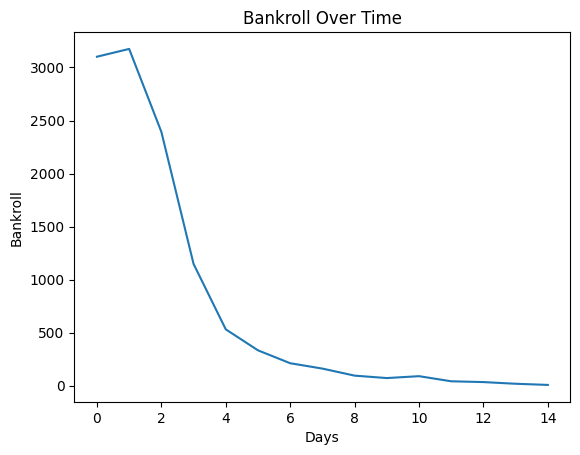

Final Bankroll: 6.890000000000708
Total Profit: -2493.109999999999


In [40]:
# Example usage with defined constants
final_bankroll, total_profit, bet_results = backtest_model(
    df=df,
    model=ml_model,
    feature_cols=df.drop(drop_cols, axis=1).columns,  # Feature columns
    label_col='q3_result',
    odds_col='Momentum',
    start_date='2024-10-22',
    end_date='2024-11-06',
    initial_bankroll=2500,
    bet_size=2, 
    threshold=1
)

# Plotting the results
plt.plot(bet_results)
plt.title('Bankroll Over Time')
plt.xlabel('Days')
plt.ylabel('Bankroll')
plt.show()

print(f"Final Bankroll: {final_bankroll}")
print(f"Total Profit: {total_profit}")

In [127]:
from selenium.webdriver.common.by import By
from IPython.display import Javascript
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from datetime import datetime
import time

team_map = {
    'Hawks': 'Atlanta',
    'Nets': 'Brooklyn',
    'Celtics': 'Boston',
    'Hornets': 'Charlotte',
    'Bulls': 'Chicago',
    'Cavaliers': 'Cleveland',
    'Mavericks': 'Dallas',
    'Nuggets': 'Denver',
    'Pistons': 'Detroit',
    'Warriors': 'Golden State',
    'Rockets': 'Houston',
    'Pacers': 'Indiana',
    'Clippers': 'LA Clippers',
    'Lakers': 'LA Lakers',
    'Grizzlies': 'Memphis',
    'Heat': 'Miami',
    'Bucks': 'Milwaukee',
    'Timberwolves': 'Minnesota',
    'Pelicans': 'New Orleans',
    'Knicks': 'New York',
    'Thunder': 'Oklahoma City',
    'Magic': 'Orlando',
    '76ers': 'Philadelphia',
    'Suns': 'Phoenix',
    'Trail Blazers': 'Portland',
    'Kings': 'Sacramento',
    'Spurs': 'San Antonio',
    'Raptors': 'Toronto',
    'Jazz': 'Utah',
    'Wizards': 'Washington'
}

# Initialize headless WebDriver
options = Options()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

# get todays date as YYYY-MM-DD
today = datetime.now().strftime('%Y-%m-%d')
driver.get(f'https://www.scoresandodds.com/nba?date={today}')

# Wait for page to load
time.sleep(3)

# Find the table by its class
tables = driver.find_elements(By.CLASS_NAME, 'event-card-table')

current_odds = {}
games = []
team = None
for table in tables:
    # Find all rows in the table
    rows = table.find_elements(By.CLASS_NAME, 'event-card-row')
    all_moves = [float(''.join(c for c in m.text if (c.isdigit() or c =='.' or c == '-'))) for m in table.find_elements(By.CSS_SELECTOR, '[data-tab*="#line-movements"] .data-value')]
    s_moves = []
    t_moves = []
    for m in all_moves:
      if abs(m) < 100:
        s_moves.append(m)
      else:
        t_moves.append(m)

    i = 0
    teams = []

    home_row = table.find_element(By.CSS_SELECTOR, '[data-side="home"]')
    away_row = table.find_element(By.CSS_SELECTOR, '[data-side="away"]')

    home_team = home_row.find_element(By.CSS_SELECTOR, '.team-name span').text
    away_team = away_row.find_element(By.CSS_SELECTOR, '.team-name span').text

    raw_h_ml = home_row.find_element(By.CSS_SELECTOR, '[data-field="current-moneyline"] .data-value').text
    raw_h_ml = -110 if raw_h_ml == 'even' else raw_h_ml
    h_ml = int(raw_h_ml)
    h_spread = float(''.join(c for c in home_row.find_element(By.CSS_SELECTOR, '[data-field="current-spread"] .data-value').text if (c.isdigit() or c == '.' or c == '-')))
    h_total = float(''.join(c for c in home_row.find_element(By.CSS_SELECTOR, '[data-field="current-total"] .data-value').text if (c.isdigit() or c == '.' or c == '-')))

    home = ['REF', h_ml, 'H', team_map[away_team], h_spread, h_total, s_moves[-3:], t_moves[-3:], 'CREW', 'UMPIRE']

    raw_a_ml = away_row.find_element(By.CSS_SELECTOR, '[data-field="current-moneyline"] .data-value').text
    raw_a_ml = -110 if raw_a_ml == 'even' else raw_a_ml
    a_ml = int(raw_a_ml)
    a_spread = float(''.join(c for c in away_row.find_element(By.CSS_SELECTOR, '[data-field="current-spread"] .data-value').text if (c.isdigit() or c == '.' or c == '-')))
    a_total = float(''.join(c for c in away_row.find_element(By.CSS_SELECTOR, '[data-field="current-total"] .data-value').text if (c.isdigit() or c == '.' or c == '-')))

    away = ['REF', a_ml, 'R', team_map[home_team], a_spread, a_total, s_moves[-3:], t_moves[-3:], 'CREW', 'UMPIRE']

    current_odds[team_map[home_team]] = home
    current_odds[team_map[away_team]] = away

driver.quit()
print('DONE')



DONE


In [129]:
from bs4 import BeautifulSoup

def parse_referee_data(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table', class_='table')
    rows = table.find_all('tr')[1:]  # Skipping the header row

    ref_data = {}
    for row in rows:
        columns = row.find_all('td')
        if len(columns) < 4:
            continue  # Skip rows that don't have enough columns

        game = columns[0].get_text(strip=True)
        crew_chief = columns[1].get_text(strip=True)
        referee = columns[2].get_text(strip=True)
        umpire = columns[3].get_text(strip=True)

        # Split the game into two teams
        teams = game.split(' @ ')
        if len(teams) != 2:
            continue  # Skip if format is not as expected
        city1 = teams[0] #_city_map.get(teams[0].split()[-1] + " " + teams[0].split()[-2], "Unknown")
        city2 = teams[1] #_city_map.get(teams[1].split()[-1] + " " + teams[1].split()[-2], "Unknown")

        ref_data[city1] = [crew_chief, referee, umpire]
        ref_data[city2] = [crew_chief, referee, umpire]

    return ref_data

def remove_ref_keys(data_dict):
    return {k: v for k, v in data_dict.items() if v[0] != 'REF'}

In [130]:
options = Options()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)
driver.get('https://official.nba.com/referee-assignments/')

# Wait for JavaScript to load
time.sleep(3)

# Get the HTML content of the page
html_content = driver.page_source

# Close the browser
driver.quit()

referee_data = parse_referee_data(html_content)

for city, refs in referee_data.items():
    try:
        if city == 'L.A. Lakers':
          city = 'LA Lakers'
        current_odds[city][0] = ' '.join(refs[0].split(' ')[:-1])
        current_odds[city][-2] = ' '.join(refs[1].split(' ')[:-1])
        current_odds[city][-1] = ' '.join(refs[2].split(' ')[:-1])
    except:
      pass

processed_data = remove_ref_keys(current_odds)
TODAY_MAP = processed_data
display(pd.DataFrame(TODAY_MAP))

,Detroit,Atlanta,Orlando,New Orleans,Charlotte,Indiana,Cleveland,Golden State,New York,Milwaukee,...,Memphis,Washington,Denver,Miami,Minnesota,Portland,Sacramento,LA Clippers,LA Lakers,Philadelphia
0,James Capers,James Capers,Pat Fraher,Pat Fraher,Josh Tiven,Josh Tiven,Ben Taylor,Ben Taylor,John Goble,John Goble,...,Bill Kennedy,Bill Kennedy,Brian Forte,Brian Forte,James Williams,James Williams,Scott Foster,Scott Foster,Zach Zarba,Zach Zarba
1,-122,102,-238,195,220,-270,-175,145,-270,220,...,-298,240,-142,120,-800,550,-250,205,-298,240
2,H,R,H,R,H,R,H,R,H,R,...,H,R,H,R,H,R,H,R,H,R
3,Atlanta,Detroit,New Orleans,Orlando,Indiana,Charlotte,Golden State,Cleveland,Milwaukee,New York,...,Washington,Memphis,Miami,Denver,Portland,Minnesota,LA Clippers,Sacramento,Philadelphia,LA Lakers
4,-1.5,1.5,-6.0,6.0,7.0,-7.0,-4.0,4.0,-7.0,7.0,...,-7.5,7.5,-2.5,2.5,-12.5,12.5,-6.5,6.5,-7.0,7.0
5,227.5,227.5,212.0,212.0,236.0,236.0,231.0,231.0,223.5,223.5,...,231.5,231.5,221.0,221.0,219.5,219.5,223.5,223.5,224.5,224.5
6,"[-1.0, -1.0, -1.5]","[-1.0, -1.0, -1.5]","[-6.0, -6.0, -6.0]","[-6.0, -6.0, -6.0]","[-7.0, -7.0, -7.0]","[-7.0, -7.0, -7.0]","[-4.0, -4.0, -4.0]","[-4.0, -4.0, -4.0]","[-7.0, -6.5, -6.5]","[-7.0, -6.5, -6.5]",...,"[-7.5, -7.5, -7.5]","[-7.5, -7.5, -7.5]","[-2.5, -2.5, -2.5]","[-2.5, -2.5, -2.5]","[-12.5, -12.5, -12.0]","[-12.5, -12.5, -12.0]","[-6.5, -6.5, -7.0]","[-6.5, -6.5, -7.0]","[-7.0, -7.0, -7.0]","[-7.0, -7.0, -7.0]"
7,"[227.5, 227.5, 227.5]","[227.5, 227.5, 227.5]","[212.0, 212.0, 211.5]","[212.0, 212.0, 211.5]","[236.0, 236.0, 236.0]","[236.0, 236.0, 236.0]","[231.0, 231.0, 231.0]","[231.0, 231.0, 231.0]","[223.5, 223.5, 223.5]","[223.5, 223.5, 223.5]",...,"[231.5, 231.5, 231.5]","[231.5, 231.5, 231.5]","[221.0, 221.0, 221.0]","[221.0, 221.0, 221.0]","[219.5, 219.5, 219.5]","[219.5, 219.5, 219.5]","[223.5, 223.5, 223.5]","[223.5, 223.5, 223.5]","[224.5, 224.0, 224.0]","[224.5, 224.0, 224.0]"
8,Ashley Moyer-Gleich,Ashley Moyer-Gleich,Ray Acosta,Ray Acosta,Andy Nagy,Andy Nagy,Rodney Mott,Rodney Mott,Tre Maddox,Tre Maddox,...,Dedric Taylor,Dedric Taylor,Natalie Sago,Natalie Sago,JB DeRosa,JB DeRosa,John Butler,John Butler,Marat Kogut,Marat Kogut
9,Nate Green,Nate Green,Derrick Collins,Derrick Collins,Intae Hwang,Intae Hwang,John Conley,John Conley,Matt Kallio,Matt Kallio,...,Michael Smith,Michael Smith,Simone Jelks,Simone Jelks,Jenna Schroeder,Jenna Schroeder,Danielle Scott,Danielle Scott,Che Flores,Che Flores


In [148]:
t_teams = list(TODAY_MAP.keys())

def get_most_recent_rows(df, teams):
    most_recent_rows = []
    for team in teams:
        team_df = df[df['TEAM'] == team]
        if not team_df.empty:
            most_recent_row = team_df.loc[team_df['DATE'].idxmax()]
            most_recent_rows.append(most_recent_row)
    return pd.DataFrame(most_recent_rows)

# Step 1: Result of the Game
def assign_opps(group):

    t1 = group.iloc[0]['Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'Avg_3_game_F', 'Avg_5_game_F', 'Season_Avg_PTS', 'Elo_Rating', 'Momentum']
    t2 = group.iloc[1]['Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'Avg_3_game_PTS', 'Avg_5_game_PTS', 'Season_Avg_PTS', 'Elo_Rating', 'Momentum']

    group.iloc[0]['Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS', 'Opp_Avg_3_game_PTS', 'Opp_Avg_5_game_PTS', 'Opp_Season_Avg_PTS', 'Opp_Elo', 'Opp_Momentum'] = t2
    group.iloc[1]['Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS', 'Opp_Avg_3_game_PTS', 'Opp_Avg_5_game_PTS', 'Opp_Season_Avg_PTS', 'Opp_Elo', 'Opp_Momentum'] = t1

    return group

# Get the most recent rows
tdf = get_most_recent_rows(df, t_teams)

ref_map = {team: details[0] for team, details in TODAY_MAP.items()}
crew_map = {team: details[-2] for team, details in TODAY_MAP.items()}
moneyline_map = {team: details[1] for team, details in TODAY_MAP.items()}
venue_map = {team: details[2] for team, details in TODAY_MAP.items()}
opp_map = {team: details[3] for team, details in TODAY_MAP.items()}
spread_map = {team: details[4] for team, details in TODAY_MAP.items()}
total_map = {team: details[5] for team, details in TODAY_MAP.items()}
s_movement_map_1 = {team: details[6][0] for team, details in TODAY_MAP.items()}
s_movement_map_2 = {team: details[6][1] for team, details in TODAY_MAP.items()}
s_movement_map_3 = {team: details[6][2] for team, details in TODAY_MAP.items()}
t_movement_map_1 = {team: details[7][0] for team, details in TODAY_MAP.items()}
t_movement_map_2 = {team: details[7][1] for team, details in TODAY_MAP.items()}
t_movement_map_3 = {team: details[7][2] for team, details in TODAY_MAP.items()}


tdf['DATE'] = tdf['DATE'].astype('datetime64[ns]')
tdf['MAIN REF'] = tdf['TEAM'].map(ref_map)
tdf['CREW'] = tdf['TEAM'].map(ref_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['CLOSING_SPREAD'] = tdf['TEAM'].map(spread_map)
tdf['CLOSING_TOTAL'] = tdf['TEAM'].map(total_map)
tdf['Opponent'] = tdf['TEAM'].map(opp_map)

tdf['SPREAD_LINE_MOVEMENT_1'] = tdf['TEAM'].map(s_movement_map_1)
tdf['SPREAD_LINE_MOVEMENT_2'] = tdf['TEAM'].map(s_movement_map_2)
tdf['SPREAD_LINE_MOVEMENT_3'] = tdf['TEAM'].map(s_movement_map_3)

tdf['TOTAL_LINE_MOVEMENT_1'] = tdf['TEAM'].map(t_movement_map_1)
tdf['TOTAL_LINE_MOVEMENT_2'] = tdf['TEAM'].map(t_movement_map_2)
tdf['TOTAL_LINE_MOVEMENT_3'] = tdf['TEAM'].map(t_movement_map_3)

In [150]:

# Step 1: Result of the Game
def assign_results(group):
    group['MAIN REF'] = [group['MAIN REF'].iloc[0]]*2
    if group.iloc[0]['PTS'] > group.iloc[1]['PTS']:
        group['Result'] = [1, 0]
    else:
        group['Result'] = [0, 1]

    group['Opp_Avg_3_game_PTS'] = [group.iloc[1]['Avg_3_game_PTS'], group.iloc[0]['Avg_3_game_PTS']]
    group['Opp_Avg_2_game_PTS'] = [group.iloc[1]['Avg_5_game_PTS'], group.iloc[0]['Avg_5_game_PTS']]
    group['Opp_Season_Avg_PTS'] = [group.iloc[1]['Season_Avg_PTS'], group.iloc[0]['Season_Avg_PTS']]

    group['Opp_Avg_3_game_POSS'] = [group.iloc[1]['Avg_3_game_POSS'], group.iloc[0]['Avg_3_game_POSS']]
    group['Opp_Avg_5_game_POSS'] = [group.iloc[1]['Avg_5_game_POSS'], group.iloc[0]['Avg_5_game_POSS']]
    group['Opp_Season_Avg_POSS'] = [group.iloc[1]['Season_Avg_POSS'], group.iloc[0]['Season_Avg_POSS']]

    group['Opp_Avg_3_game_PACE'] = [group.iloc[1]['Avg_3_game_PACE'], group.iloc[0]['Avg_3_game_PACE']]
    group['Opp_Avg_5_game_PACE'] = [group.iloc[1]['Avg_5_game_PACE'], group.iloc[0]['Avg_5_game_PACE']]
    group['Opp_Season_Avg_PACE'] = [group.iloc[1]['Season_Avg_PACE'], group.iloc[0]['Season_Avg_PACE']]

    group['Opp_Avg_3_game_DEFF'] = [group.iloc[1]['Avg_3_game_DEFF'], group.iloc[0]['Avg_3_game_DEFF']]
    group['Opp_Avg_5_game_DEFF'] = [group.iloc[1]['Avg_5_game_DEFF'], group.iloc[0]['Avg_5_game_DEFF']]
    group['Opp_Season_Avg_DEFF'] = [group.iloc[1]['Season_Avg_DEFF'], group.iloc[0]['Season_Avg_DEFF']]

    group['Opp_Avg_3_game_OEFF'] = [group.iloc[1]['Avg_3_game_OEFF'], group.iloc[0]['Avg_3_game_OEFF']]
    group['Opp_Avg_5_game_OEFF'] = [group.iloc[1]['Avg_5_game_OEFF'], group.iloc[0]['Avg_5_game_OEFF']]
    group['Opp_Season_Avg_OEFF'] = [group.iloc[1]['Season_Avg_OEFF'], group.iloc[0]['Season_Avg_OEFF']]

    return group


# Step 2: Average Points
tdf['Avg_3_game_PTS'] = tdf.groupby(['TEAM',])['PTS'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_PTS'] = tdf.groupby(['TEAM',])['PTS'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_PTS'] = tdf.groupby(['TEAM',])['PTS'].transform('mean')

tdf['Avg_3_game_POSS'] = tdf.groupby(['TEAM',])['POSS'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_POSS'] = tdf.groupby(['TEAM',])['POSS'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_POSS'] = tdf.groupby(['TEAM',])['POSS'].transform('mean')

tdf['Avg_3_game_PACE'] = tdf.groupby(['TEAM',])['PACE'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_PACE'] = tdf.groupby(['TEAM',])['PACE'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_PACE'] = tdf.groupby(['TEAM',])['PACE'].transform('mean')

tdf['Avg_3_game_OEFF'] = tdf.groupby(['TEAM',])['OEFF'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_OEFF'] = tdf.groupby(['TEAM',])['OEFF'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_OEFF'] = tdf.groupby(['TEAM',])['OEFF'].transform('mean')

tdf['Avg_3_game_DEFF'] = tdf.groupby(['TEAM',])['DEFF'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_DEFF'] = tdf.groupby(['TEAM',])['DEFF'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_DEFF'] = tdf.groupby(['TEAM',])['DEFF'].transform('mean')


def categorize_rest_days(team, today_date, df):
    # Filter DataFrame for the specific team and sort by date
    team_games = df[df['TEAM'] == team].sort_values(by='DATE')

    # Find games up to today's date
    past_games = team_games[team_games['DATE'] < today_date]

    # Check if no games played
    if past_games.empty:
        return 'No games played'

    # Calculate the number of days since the last game
    last_game_date = past_games.iloc[-1]['DATE']
    days_since_last_game = (today_date - last_game_date).days - 1

    # Check for 3 games in 4 days (including B2B scenarios)
    if len(past_games) >= 3 and (today_date - past_games.iloc[-3]['DATE']).days <= 4:
        return '3IN4-B2B' if days_since_last_game == 0 else '3IN4'

    # Check for 4 games in 5 days (including B2B scenarios)
    if len(past_games) >= 4 and (today_date - past_games.iloc[-4]['DATE']).days <= 5:
        return '4IN5-B2B' if days_since_last_game == 0 else '4IN5'

    # Standard cases
    # Check for back-to-back games
    if days_since_last_game == 0:
        return 'B2B'
    if days_since_last_game >= 3:
        return '3+'
    elif days_since_last_game == 2:
        return '2'
    elif days_since_last_game == 1:
        return '1'

    return 'No category'

today_date = pd.to_datetime('today').normalize()

tdf['TEAM_REST_DAYS'] = tdf.apply(lambda row: categorize_rest_days(row['TEAM'], today_date, tdf), axis=1)

ref_map = {team: details[0] for team, details in TODAY_MAP.items()}
moneyline_map = {team: details[1] for team, details in TODAY_MAP.items()}
venue_map = {team: details[2] for team, details in TODAY_MAP.items()}
opp_map = {team: details[3] for team, details in TODAY_MAP.items()}
spread_map = {team: details[4] for team, details in TODAY_MAP.items()}
total_map = {team: details[5] for team, details in TODAY_MAP.items()}
s_movement_map_1 = {team: details[6][0] for team, details in TODAY_MAP.items()}
s_movement_map_2 = {team: details[6][1] for team, details in TODAY_MAP.items()}
s_movement_map_3 = {team: details[6][2] for team, details in TODAY_MAP.items()}
t_movement_map_1 = {team: details[7][0] for team, details in TODAY_MAP.items()}
t_movement_map_2 = {team: details[7][1] for team, details in TODAY_MAP.items()}
t_movement_map_3 = {team: details[7][2] for team, details in TODAY_MAP.items()}


tdf['DATE'] = tdf['DATE'].astype('datetime64[ns]')
tdf['MAIN REF'] = tdf['TEAM'].map(ref_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['CLOSING_SPREAD'] = tdf['TEAM'].map(spread_map)
tdf['CLOSING_TOTAL'] = tdf['TEAM'].map(total_map)
tdf['Opponent'] = tdf['TEAM'].map(opp_map)

tdf['SPREAD_LINE_MOVEMENT_1'] = tdf['TEAM'].map(s_movement_map_1)
tdf['SPREAD_LINE_MOVEMENT_2'] = tdf['TEAM'].map(s_movement_map_2)
tdf['SPREAD_LINE_MOVEMENT_3'] = tdf['TEAM'].map(s_movement_map_3)

tdf['TOTAL_LINE_MOVEMENT_1'] = tdf['TEAM'].map(t_movement_map_1)
tdf['TOTAL_LINE_MOVEMENT_2'] = tdf['TEAM'].map(t_movement_map_2)
tdf['TOTAL_LINE_MOVEMENT_3'] = tdf['TEAM'].map(t_movement_map_3)

tdf['SPREAD_LINE_MOVEMENT_1'] = tdf['Opponent'].map(s_movement_map_1)
tdf['SPREAD_LINE_MOVEMENT_2'] = tdf['Opponent'].map(s_movement_map_2)
tdf['SPREAD_LINE_MOVEMENT_3'] = tdf['Opponent'].map(s_movement_map_3)

tdf['TOTAL_LINE_MOVEMENT_1'] = tdf['Opponent'].map(t_movement_map_1)
tdf['TOTAL_LINE_MOVEMENT_2'] = tdf['Opponent'].map(t_movement_map_2)
tdf['TOTAL_LINE_MOVEMENT_3'] = tdf['Opponent'].map(t_movement_map_3)

refs_2019 = pd.read_csv('../historical_data/2018-2019.csv')
refs_2020 = pd.read_csv('../historical_data/2019-2020.csv')
refs_2021 = pd.read_csv('../historical_data/2020-2021.csv')
refs_2022 = pd.read_csv('../historical_data/2021_2022.csv')
refs_2023 = pd.read_csv('../historical_data/2022-2023.csv')
refs_2024 = pd.read_csv('../historical_data/2023-2024.csv')

refs = pd.concat([refs_2019, refs_2020, refs_2021, refs_2022, refs_2023, refs_2024])
tdf = tdf.merge(refs.groupby('REFEREE').first(), how='left', left_on='MAIN REF', right_on='REFEREE', suffixes=['x', ''])
tdf = tdf.sort_values('DATE')


#tdf[['MONEYLINE', 'DATE']].head(10)

In [154]:
def probability_to_american_odds(probability):
    if probability < 0 or probability > 1:
        raise ValueError("Probability must be between 0 and 1")

    if probability == 0.5:
        return 100  # Even odds

    if probability > 0.5:
        return int(-100 * (probability / (1 - probability)))
    else:
        return int(100 * ((1 - probability) / probability))


In [155]:

temp = tdf[df.drop(['spread_result', 'ml_result', 'total_result', 'q3_result', 'DATE', 'OEFF', 'PTS', 'PACE', 'DEFF', 'POSS'], axis=1).columns]
#temp.columns = train_cols_final
#display(temp)

# get the dataframe to predict for today
X = temp.copy()
X['MONEYLINE'] = X['TEAM'].map(moneyline_map)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].replace('Even', '-100', regex=True).replace('--', '-100', regex=True).replace('BLANK_STRING', '-100', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].fillna(0).astype(float)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1

# get predictions for today from the ensemble
probabilities = spread_model.predict_proba(X)[:, 1]

# get predictions
predictions = np.array([x > 0.5 for x in probabilities])

# store probabilities in dataframe
X['prob'] = probabilities

# get the odds
odds = X['MONEYLINE'].values
ps = {team: prob for team, prob in zip(X['TEAM'].values, probabilities)}

normed_odds = {team: ps[team]/(ps[team] + ps[opp]) for team, opp in zip(X['TEAM'], X['Opponent'])}
do_bet = {team: normed_odds[team] > normed_odds[opp] for team, opp in zip(X['TEAM'], X['Opponent'])}

# go over each team for today
for team, win, prob, opp, elo, mom in zip(X['TEAM'].values, probabilities, probabilities, X['Opponent'].values, X['Elo_Rating'].values, X['Momentum'].values):


  # get this team odds
  o = -100 if moneyline_map[team] == 'Even' else int(moneyline_map[team])
  odd = str(o) if o < 0 else f'+{o}'

  # get opp odds
  o2 = -100 if moneyline_map[opp] == 'Even' else int(moneyline_map[opp])
  odd2 = str(o2) if o2 < 0 else f'+{o2}'

  # get out odds
  #print(normed_odds[team])
  our_line = probability_to_american_odds(normed_odds[team])
  our_line = str(our_line) if our_line < 0 else f'+{our_line}'

  # get our opp odds
  our_opp_line = probability_to_american_odds(normed_odds[opp])
  our_opp_line = str(our_opp_line) if our_opp_line < 0 else f'+{our_opp_line}'

  # get the bet sizing
  bet = kelly_criterion(100, normed_odds[team], o, temper=0.2)

  # tab character for spacing the prints
  tab = '&nbsp;&nbsp;&nbsp;&nbsp;'

  # make picks
  if do_bet[team] and ps[team] - ps[opp] > 0.25:
    win_color = 'green'
    lose_color = 'red'
    b = f'Stright bet {bet}u to win {calculate_profit(o, bet),2}u' if bet > 0 else 'Don\'t bet this straight - parlay only'

    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{normed_odds[team]*100, 2}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{normed_odds[opp]*100, 2}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')

  elif do_bet[team]:
    win_color = '#E4CD05'
    lose_color = 'orange'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'
    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{normed_odds[team]*100, 2}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{normed_odds[opp]*100, 2}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')


C:\Users\chcro\AppData\Local\Temp\ipykernel_6668\135658221.py:103: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
C:\Users\chcro\AppData\Local\Temp\ipykernel_6668\135658221.py:104: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


In [156]:

temp = tdf[df.drop(['spread_result', 'ml_result', 'total_result', 'q3_result', 'DATE', 'OEFF', 'PTS', 'PACE', 'DEFF', 'POSS'], axis=1).columns]
#temp.columns = train_cols_final
#display(temp)

# get the dataframe to predict for today
X = temp.copy()
X['MONEYLINE'] = X['TEAM'].map(moneyline_map)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].replace('Even', '-100', regex=True).replace('--', '-100', regex=True).replace('BLANK_STRING', '-100', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].fillna(0).astype(float)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1

# get predictions for today from the ensemble
probabilities = ml_model.predict_proba(X)[:, 1]

# get predictions
predictions = np.array([x > 0.5 for x in probabilities])

# store probabilities in dataframe
X['prob'] = probabilities

# get the odds
odds = X['MONEYLINE'].values
ps = {team: prob for team, prob in zip(X['TEAM'].values, probabilities)}

normed_odds = {team: ps[team]/(ps[team] + ps[opp]) for team, opp in zip(X['TEAM'], X['Opponent'])}
do_bet = {team: normed_odds[team] > normed_odds[opp] for team, opp in zip(X['TEAM'], X['Opponent'])}

# go over each team for today
for team, win, prob, opp, elo, mom in zip(X['TEAM'].values, probabilities, probabilities, X['Opponent'].values, X['Elo_Rating'].values, X['Momentum'].values):


  # get this team odds
  o = -100 if moneyline_map[team] == 'Even' else int(moneyline_map[team])
  odd = str(o) if o < 0 else f'+{o}'

  # get opp odds
  o2 = -100 if moneyline_map[opp] == 'Even' else int(moneyline_map[opp])
  odd2 = str(o2) if o2 < 0 else f'+{o2}'

  # get out odds
  #print(normed_odds[team])
  our_line = probability_to_american_odds(normed_odds[team])
  our_line = str(our_line) if our_line < 0 else f'+{our_line}'

  # get our opp odds
  our_opp_line = probability_to_american_odds(normed_odds[opp])
  our_opp_line = str(our_opp_line) if our_opp_line < 0 else f'+{our_opp_line}'

  # get the bet sizing
  bet = kelly_criterion(100, normed_odds[team], o, temper=0.2)

  # tab character for spacing the prints
  tab = '&nbsp;&nbsp;&nbsp;&nbsp;'

  # make picks
  if do_bet[team] and ps[team] - ps[opp] > 0.25:
    win_color = 'green'
    lose_color = 'red'
    b = f'Stright bet {bet}u to win {calculate_profit(o, bet),2}u' if bet > 0 else 'Don\'t bet this straight - parlay only'

    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{normed_odds[team]*100, 2}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{normed_odds[opp]*100, 2}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')

  elif do_bet[team]:
    win_color = '#E4CD05'
    lose_color = 'orange'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'
    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{normed_odds[team]*100, 2}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{normed_odds[opp]*100, 2}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')


C:\Users\chcro\AppData\Local\Temp\ipykernel_6668\377219501.py:79: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
C:\Users\chcro\AppData\Local\Temp\ipykernel_6668\377219501.py:80: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


C:\Users\chcro\AppData\Local\Temp\ipykernel_6668\377219501.py:103: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
C:\Users\chcro\AppData\Local\Temp\ipykernel_6668\377219501.py:104: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________
